## Logistic Regression Implementation on (scaled) Reduced Dataset with PCA

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data) and reduced dataset

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Read Train Data

In [4]:
columns_PCA = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
           'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18']

In [5]:
X_train= pd.read_csv('../../DimensionalityReductionData/X_train_PCA.csv', names=columns_PCA)
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0.230656,-0.540199,0.275241,0.348734,0.442168,-0.244893,-0.305579,-0.388014,0.483440,-0.050057,0.114171,0.037729,-0.133432,0.084029,0.211571,-0.000299,0.276030,0.133585
1,-0.578532,-0.273813,-0.207024,0.202237,0.438744,-0.422858,0.108360,-0.469457,0.476055,0.098184,0.022312,0.125669,0.187688,-0.019637,-0.181937,-0.064250,-0.107400,0.057437
2,-0.207271,1.096294,-0.124524,-0.014919,0.302102,0.276747,0.024807,-0.079499,0.016929,0.018033,-0.071089,-0.003510,-0.020689,-0.065503,-0.117356,-0.056667,-0.133169,-0.121348
3,-0.549501,-0.271749,0.166219,0.161220,0.278617,-0.671476,-0.287128,0.591844,-0.668737,-0.173965,-0.421168,-0.101647,-0.332900,-0.157359,0.086729,0.130933,-0.221770,-0.134654
4,-0.605220,-0.210550,-0.406984,0.455269,-0.336895,0.182399,0.298030,0.309622,0.071143,-0.035126,0.191219,-0.142084,0.191455,0.036069,-0.138503,0.001297,-0.030649,0.106555


Read Test Data

In [6]:
X_test = pd.read_csv('../../DimensionalityReductionData/X_test_PCA.csv', names=columns_PCA)
X_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0.325189,-0.474065,0.148350,0.015025,0.453967,-0.382437,0.009063,0.696200,-0.577426,-0.029937,-0.099144,0.654157,0.475839,0.289828,-0.034359,-0.584359,0.783886,-0.206918
1,-0.553038,-0.060147,0.246432,-0.094217,-0.152499,-0.133879,0.046601,-0.127948,-0.063073,-0.262155,0.036293,-0.084048,-0.114584,0.030450,0.102251,-0.048580,0.100263,0.069443
2,-0.543513,-0.099255,0.273981,-0.140697,-0.202855,-0.145719,-0.165479,-0.040533,-0.045461,-0.230001,0.047889,-0.076919,-0.013481,0.034937,0.047416,-0.038551,0.040234,0.096922
3,0.604992,0.850389,0.205670,0.134501,0.422158,0.448003,-0.124164,-0.002779,0.023872,-0.005055,-0.010426,-0.033946,-0.181834,0.042114,0.137483,0.011521,0.138021,0.009279
4,-0.222045,1.101761,-0.093482,-0.005867,0.283825,0.294311,0.032426,-0.116046,0.009989,-0.017200,-0.072850,-0.009081,-0.097862,-0.067777,-0.070239,-0.058562,-0.076902,-0.149065


Do Train-Test Split to define y_train, y_test (both are raings)
!!!! IMPORTANT use random_state as defined in Dimension Reduction DATA SPLIT!!!!

In [7]:
y_train, y_test = train_test_split(df_scaled['averageRating'], test_size=0.2, random_state=42)

Now everything is defined (X_train, X_test, y_train, y_test)

Save and print metrics

In [8]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

Model fit

In [9]:
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=23)

In [10]:
predictions = model.predict(X_test)

Metrics for LR-PCA_untuned:
Accuracy: 0.7212
Weighted F1: 0.7211
Weighted Precision: 0.7211
Weighted Recall: 0.7212
Macro-Averaged Precision: 0.7211
Macro-Averaged Recall: 0.7208
F1: [0.7306083  0.71108043]
Precision: [0.72385204 0.71827057]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.74      0.73      1539
     Class 1       0.72      0.70      0.71      1463

    accuracy                           0.72      3002
   macro avg       0.72      0.72      0.72      3002
weighted avg       0.72      0.72      0.72      3002

Confusion Matrix


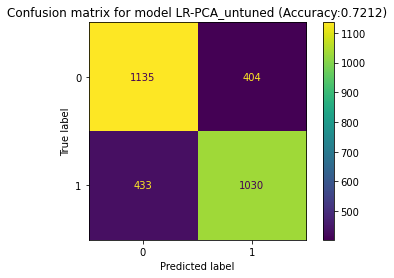

In [11]:
model_metrics = calculate_metrics('LR-PCA_untuned', y_test, predictions)

In [12]:
# Apar warning-uri ptc nu converge daca max_iter e mic (<100)
# Maximu pe care l-am pus e 10k si acolo nu apare niciun warning dar am lasat ca lista
# Ptc modelele cele mai bune sunt la la max_iter <500
warnings.filterwarnings(action='ignore')

## Grid Search with Cross-Validation

In [13]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 100, 200, 500, 100, 1000, 5000],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search_cv = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                               param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

Results of the best model 

In [14]:
accuracy_cv = best_model_cv.score(X_test, y_test)

print("Best Hyperparameters:", best_params_cv)
print("Accuracy:", accuracy_cv)

Best Hyperparameters: {'C': 10, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.7205196535642905


Results of best models Grid Search CV

In [15]:
df_cv = pd.DataFrame(grid_search_cv.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_cv = df_cv[['params', 'mean_test_score']]
df_results_cv_sorted = df_results_cv.sort_values(by='mean_test_score', ascending=False)

print(df_results_cv_sorted.head(5))

                                                params  mean_test_score
115  {'C': 10, 'max_iter': 10, 'penalty': 'l2', 'so...         0.716535
124  {'C': 10, 'max_iter': 500, 'penalty': 'l1', 's...         0.716368
118  {'C': 10, 'max_iter': 100, 'penalty': 'l2', 's...         0.716368
119  {'C': 10, 'max_iter': 100, 'penalty': 'l2', 's...         0.716368
120  {'C': 10, 'max_iter': 200, 'penalty': 'l1', 's...         0.716368


Metrics for LR-PCA_CV1_best:
Accuracy: 0.7205
Weighted F1: 0.7204
Weighted Precision: 0.7205
Weighted Recall: 0.7205
Macro-Averaged Precision: 0.7204
Macro-Averaged Recall: 0.7200
F1: [0.73048506 0.709789  ]
Precision: [0.72236341 0.71848739]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.74      0.73      1539
     Class 1       0.72      0.70      0.71      1463

    accuracy                           0.72      3002
   macro avg       0.72      0.72      0.72      3002
weighted avg       0.72      0.72      0.72      3002

Confusion Matrix


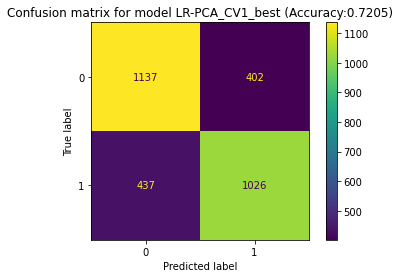

In [16]:
# Use best parameters to make predictions
predictions_cv = best_model_cv.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR-PCA_CV1_best', y_test, predictions_cv)])

## Grid Search Stratified K Fold Validation

In [17]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_skf = GridSearchCV(estimator=LogisticRegression(random_state=seed), 
                           param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search_skf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_skf = grid_search_skf.best_params_
best_model_skf = grid_search_skf.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters with Stratified K-Fold:", best_params_skf)
print("Accuracy with Stratified K-Fold:", accuracy)


Best Hyperparameters with Stratified K-Fold: {'C': 10, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
Accuracy with Stratified K-Fold: 0.7205196535642905


Results of the best model 

In [18]:
accuracy_skf = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters:", best_params_skf)
print("Accuracy:", accuracy_skf)

Best Hyperparameters: {'C': 10, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.7205196535642905


Results of best models Grid Search CV

In [19]:
df_skf = pd.DataFrame(grid_search_skf.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_skf = df_skf[['params', 'mean_test_score']]
df_results_skf_sorted = df_results_skf.sort_values(by='mean_test_score', ascending=False)

print(df_results_skf_sorted.head(5))

                                                params  mean_test_score
115  {'C': 10, 'max_iter': 10, 'penalty': 'l2', 'so...         0.715618
143  {'C': 100, 'max_iter': 10, 'penalty': 'l2', 's...         0.715535
113  {'C': 10, 'max_iter': 10, 'penalty': 'l1', 'so...         0.715535
141  {'C': 100, 'max_iter': 10, 'penalty': 'l1', 's...         0.715535
85   {'C': 1, 'max_iter': 10, 'penalty': 'l1', 'sol...         0.715452


Metrics for LR-PCA_skf_best:
Accuracy: 0.7205
Weighted F1: 0.7204
Weighted Precision: 0.7205
Weighted Recall: 0.7205
Macro-Averaged Precision: 0.7204
Macro-Averaged Recall: 0.7200
F1: [0.73048506 0.709789  ]
Precision: [0.72236341 0.71848739]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.74      0.73      1539
     Class 1       0.72      0.70      0.71      1463

    accuracy                           0.72      3002
   macro avg       0.72      0.72      0.72      3002
weighted avg       0.72      0.72      0.72      3002

Confusion Matrix


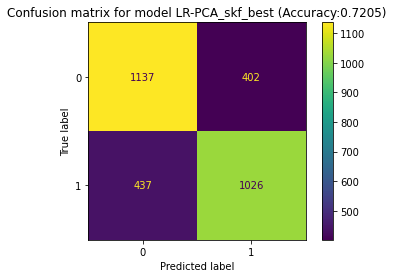

In [20]:
# Use best parameters to make predictions
predictions_skf = best_model_skf.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR-PCA_skf_best', y_test, predictions_skf)])

Next maybe add elastic search as penalty? only works with saga solver

# Tune with Optuna

In [21]:
def objective(trial):
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [22]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 20:26:47,021] A new study created in memory with name: no-name-19651e98-3500-4d63-ba79-2b359275a920
[I 2024-06-09 20:26:47,121] Trial 0 finished with value: 0.7208527648234511 and parameters: {'penalty': 'l2', 'C': 1.978696921972353, 'max_iter': 354, 'solver': 'saga'}. Best is trial 0 with value: 0.7208527648234511.
[I 2024-06-09 20:26:47,181] Trial 1 finished with value: 0.7218520986009327 and parameters: {'penalty': 'l2', 'C': 0.7147547361025183, 'max_iter': 471, 'solver': 'saga'}. Best is trial 1 with value: 0.7218520986009327.
[I 2024-06-09 20:26:47,204] Trial 2 finished with value: 0.7211858760826116 and parameters: {'penalty': 'l1', 'C': 0.5871453092844537, 'max_iter': 981, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7218520986009327.
[I 2024-06-09 20:26:47,228] Trial 3 finished with value: 0.7208527648234511 and parameters: {'penalty': 'l1', 'C': 2.9335873033004263, 'max_iter': 664, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7218520986009327.
[

Best Hyperparameters: {'penalty': 'l2', 'C': 0.02150458112009587, 'max_iter': 525, 'solver': 'saga'}
Best Accuracy: 0.7268487674883412


In [23]:
# Get best trials
trials_OTP1 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP1 = trials_OTP1.sort_values(by='value', ascending=False).head(10)
top_trials_OTP1

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_penalty,params_solver,state
127,127,0.726849,2024-06-09 20:26:56.117133,2024-06-09 20:26:56.184134,0 days 00:00:00.067001,0.021505,525,l2,saga,COMPLETE
186,186,0.726849,2024-06-09 20:26:59.620202,2024-06-09 20:26:59.643201,0 days 00:00:00.022999,0.035316,394,l2,liblinear,COMPLETE
164,164,0.726516,2024-06-09 20:26:58.149116,2024-06-09 20:26:58.224108,0 days 00:00:00.074992,0.027644,517,l2,liblinear,COMPLETE
109,109,0.726516,2024-06-09 20:26:54.531578,2024-06-09 20:26:54.557577,0 days 00:00:00.025999,0.030447,546,l2,liblinear,COMPLETE
149,149,0.726183,2024-06-09 20:26:57.377116,2024-06-09 20:26:57.435115,0 days 00:00:00.057999,0.126562,939,l2,saga,COMPLETE
122,122,0.726183,2024-06-09 20:26:55.941136,2024-06-09 20:26:55.963134,0 days 00:00:00.021998,0.018149,294,l2,liblinear,COMPLETE
182,182,0.726183,2024-06-09 20:26:59.420206,2024-06-09 20:26:59.453205,0 days 00:00:00.032999,0.017193,184,l2,liblinear,COMPLETE
133,133,0.726183,2024-06-09 20:26:56.541128,2024-06-09 20:26:56.581137,0 days 00:00:00.040009,0.028535,988,l2,liblinear,COMPLETE
194,194,0.725849,2024-06-09 20:26:59.957212,2024-06-09 20:26:59.983371,0 days 00:00:00.026159,0.020272,557,l2,liblinear,COMPLETE
125,125,0.725516,2024-06-09 20:26:56.017135,2024-06-09 20:26:56.083133,0 days 00:00:00.065998,0.105505,164,l2,saga,COMPLETE


Metrics for LR-PCA_OPT1_best:
Accuracy: 0.7268
Weighted F1: 0.7267
Weighted Precision: 0.7268
Weighted Recall: 0.7268
Macro-Averaged Precision: 0.7268
Macro-Averaged Recall: 0.7263
F1: [0.73717949 0.71567268]
Precision: [0.72738773 0.72624912]
classification report
              precision    recall  f1-score   support

     Class 0       0.73      0.75      0.74      1539
     Class 1       0.73      0.71      0.72      1463

    accuracy                           0.73      3002
   macro avg       0.73      0.73      0.73      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


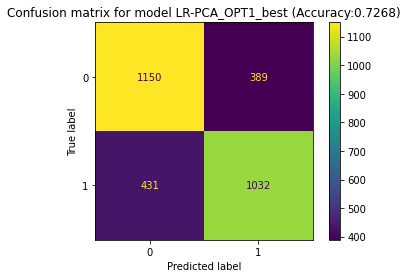

In [24]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt1 = best_model.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR-PCA_OPT1_best', y_test, predictions_opt1)])

In [25]:
study.best_params

{'penalty': 'l2', 'C': 0.02150458112009587, 'max_iter': 525, 'solver': 'saga'}

In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_parallel_coordinate(study)

In [28]:
optuna.visualization.plot_slice(study, params=['penalty', 'C', 'max_iter', 'solver'])

In [29]:
optuna.visualization.plot_param_importances(study)

In [30]:
optuna.visualization.plot_edf(study)

Enlarge 'C' range and add elasticnet parameter (comes with l1_ratio)

In [31]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [32]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 20:27:02,528] A new study created in memory with name: no-name-fa19efb9-bae1-4a52-848f-96a8c3e02fca
[I 2024-06-09 20:27:02,777] Trial 0 finished with value: 0.7211858760826116 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7211858760826116.
[I 2024-06-09 20:27:02,903] Trial 1 finished with value: 0.7245169886742172 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 0.07659165484895042, 'max_iter': 718, 'solver': 'saga'}. Best is trial 1 with value: 0.7245169886742172.
[I 2024-06-09 20:27:03,063] Trial 2 finished with value: 0.7215189873417721 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 0.37133840345513924, 'max_iter': 656, 'solver': 'saga'}. Best is trial 1 with value: 0.7245169886742172.
[I 2024-06-09 20:27:03,173] Trial 3 finished with value: 0.7171885409726849 and parameters: {'l1_ratio': 0.

Best Hyperparameters: {'l1_ratio': 0.16458012282314227, 'penalty': 'elasticnet', 'C': 0.026813954619397493, 'max_iter': 272, 'solver': 'saga'}
Best Accuracy: 0.7271818787475016


In [33]:
# Get best trials
trials_OTP2 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP2 = trials_OTP2.sort_values(by='value', ascending=False).head(10)
top_trials_OTP2

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
156,156,0.727182,2024-06-09 20:27:17.743865,2024-06-09 20:27:17.817863,0 days 00:00:00.073998,0.026814,0.164580,272,elasticnet,saga,COMPLETE
161,161,0.726849,2024-06-09 20:27:18.185858,2024-06-09 20:27:18.266857,0 days 00:00:00.080999,0.034375,0.048185,112,elasticnet,saga,COMPLETE
18,18,0.726849,2024-06-09 20:27:04.567071,2024-06-09 20:27:04.640037,0 days 00:00:00.072966,0.020712,0.231833,519,elasticnet,saga,COMPLETE
63,63,0.726849,2024-06-09 20:27:08.743986,2024-06-09 20:27:08.825981,0 days 00:00:00.081995,0.013035,0.217494,562,elasticnet,saga,COMPLETE
147,147,0.726516,2024-06-09 20:27:16.999871,2024-06-09 20:27:17.073871,0 days 00:00:00.074000,0.023281,0.179672,940,elasticnet,saga,COMPLETE
54,54,0.726516,2024-06-09 20:27:07.705996,2024-06-09 20:27:07.787027,0 days 00:00:00.081031,0.030103,0.148848,226,elasticnet,saga,COMPLETE
91,91,0.725849,2024-06-09 20:27:11.620949,2024-06-09 20:27:11.724944,0 days 00:00:00.103995,0.031728,0.486079,856,elasticnet,saga,COMPLETE
103,103,0.725849,2024-06-09 20:27:12.715930,2024-06-09 20:27:12.799930,0 days 00:00:00.084000,0.122088,0.088715,408,elasticnet,saga,COMPLETE
92,92,0.725849,2024-06-09 20:27:11.725943,2024-06-09 20:27:11.808943,0 days 00:00:00.083000,0.027213,0.382405,960,elasticnet,saga,COMPLETE
199,199,0.725516,2024-06-09 20:27:22.262801,2024-06-09 20:27:22.338803,0 days 00:00:00.076002,0.016180,0.123350,276,elasticnet,saga,COMPLETE


Metrics for LR-PCA_OPT2_best:
Accuracy: 0.7272
Weighted F1: 0.7270
Weighted Precision: 0.7272
Weighted Recall: 0.7272
Macro-Averaged Precision: 0.7272
Macro-Averaged Recall: 0.7266
F1: [0.73758411 0.71592092]
Precision: [0.72756005 0.72676056]
classification report
              precision    recall  f1-score   support

     Class 0       0.73      0.75      0.74      1539
     Class 1       0.73      0.71      0.72      1463

    accuracy                           0.73      3002
   macro avg       0.73      0.73      0.73      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


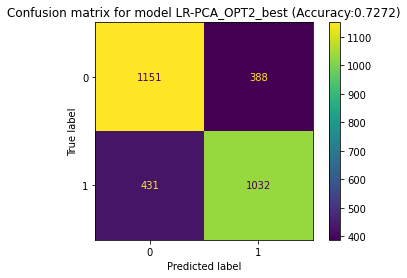

In [34]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt2 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR-PCA_OPT2_best', y_test, predictions_opt2)])

In [35]:
optuna.visualization.plot_param_importances(study)

Make 'C' interval uniform (as it remains the most important hyperparameter)

In [36]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_uniform('C', 0.01, 100)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [37]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 20:27:23,849] A new study created in memory with name: no-name-0c19ee88-5a10-446b-a305-f58e359d9efe
[I 2024-06-09 20:27:24,023] Trial 0 finished with value: 0.7211858760826116 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7211858760826116.
[I 2024-06-09 20:27:24,131] Trial 1 finished with value: 0.7205196535642905 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 22.112325872532644, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7211858760826116.
[I 2024-06-09 20:27:24,226] Trial 2 finished with value: 0.7211858760826116 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 39.25032222183841, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7211858760826116.
[I 2024-06-09 20:27:24,313] Trial 3 finished with value: 0.7215189873417721 and parameters: {'l1_ratio': 0.411

Best Hyperparameters: {'l1_ratio': 0.21285193174839834, 'penalty': 'elasticnet', 'C': 0.652427745472789, 'max_iter': 688, 'solver': 'saga'}
Best Accuracy: 0.7218520986009327


In [38]:
# Get best trials
trials_OTP3 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP3 = trials_OTP3.sort_values(by='value', ascending=False).head(10)
top_trials_OTP3

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
191,191,0.721852,2024-06-09 20:27:46.818488,2024-06-09 20:27:46.940485,0 days 00:00:00.121997,0.652428,0.212852,688,elasticnet,saga,COMPLETE
82,82,0.721519,2024-06-09 20:27:33.262668,2024-06-09 20:27:33.359681,0 days 00:00:00.097013,0.317833,0.429542,657,elasticnet,saga,COMPLETE
3,3,0.721519,2024-06-09 20:27:24.227787,2024-06-09 20:27:24.313787,0 days 00:00:00.086000,0.256463,0.411930,896,elasticnet,saga,COMPLETE
139,139,0.721519,2024-06-09 20:27:39.913578,2024-06-09 20:27:39.990579,0 days 00:00:00.077001,0.732726,0.314704,267,elasticnet,saga,COMPLETE
173,173,0.721519,2024-06-09 20:27:45.073510,2024-06-09 20:27:45.163510,0 days 00:00:00.090000,0.117680,0.426265,138,elasticnet,saga,COMPLETE
0,0,0.721186,2024-06-09 20:27:23.853794,2024-06-09 20:27:24.022781,0 days 00:00:00.168987,94.696791,0.517298,789,elasticnet,saga,COMPLETE
131,131,0.721186,2024-06-09 20:27:39.150591,2024-06-09 20:27:39.255588,0 days 00:00:00.104997,72.450796,0.465636,174,elasticnet,saga,COMPLETE
123,123,0.721186,2024-06-09 20:27:38.247632,2024-06-09 20:27:38.344599,0 days 00:00:00.096967,73.174067,0.633776,971,elasticnet,saga,COMPLETE
124,124,0.721186,2024-06-09 20:27:38.346603,2024-06-09 20:27:38.459602,0 days 00:00:00.112999,68.324921,0.087747,612,elasticnet,saga,COMPLETE
125,125,0.721186,2024-06-09 20:27:38.460604,2024-06-09 20:27:38.585597,0 days 00:00:00.124993,46.342253,0.169274,111,elasticnet,saga,COMPLETE


Metrics for LR-PCA_OPT3_best:
Accuracy: 0.7219
Weighted F1: 0.7218
Weighted Precision: 0.7218
Weighted Recall: 0.7219
Macro-Averaged Precision: 0.7217
Macro-Averaged Recall: 0.7214
F1: [0.73125201 0.7117708 ]
Precision: [0.7244898  0.71896792]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.74      0.73      1539
     Class 1       0.72      0.70      0.71      1463

    accuracy                           0.72      3002
   macro avg       0.72      0.72      0.72      3002
weighted avg       0.72      0.72      0.72      3002

Confusion Matrix


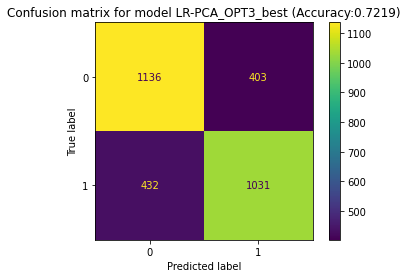

In [39]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt3 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR-PCA_OPT3_best', y_test, predictions_opt3)])

end

In [40]:
model_metrics

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
LR-PCA_untuned,0.721186,0.721092,0.721132,0.721186,0.721061,0.720762,[0.7306083 0.71108043],[0.72385204 0.71827057]
LR-PCA_CV1_best,0.720520,0.720399,0.720474,0.720520,0.720425,0.720045,[0.73048506 0.709789 ],[0.72236341 0.71848739]
LR-PCA_skf_best,0.720520,0.720399,0.720474,0.720520,0.720425,0.720045,[0.73048506 0.709789 ],[0.72236341 0.71848739]
LR-PCA_OPT1_best,0.726849,0.726698,0.726833,0.726849,0.726818,0.726319,[0.73717949 0.71567268],[0.72738773 0.72624912]
LR-PCA_OPT2_best,0.727182,0.727027,0.727170,0.727182,0.727160,0.726644,[0.73758411 0.71592092],[0.72756005 0.72676056]
LR-PCA_OPT3_best,0.721852,0.721758,0.721799,0.721852,0.721729,0.721429,[0.73125201 0.7117708 ],[0.7244898 0.71896792]
